<a href="https://colab.research.google.com/github/kopalgarg/variant-classification-ml-django/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# array operations
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# feature engineering
from sklearn.feature_extraction import FeatureHasher
# ml operations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [95]:
# columns (0,38,40) have mixed types so specifying dtype option while importing 
df = pd.read_csv('clinvar_conflicting.csv', dtype={'CHROM': str, 38: str, 40: object})

In [96]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,CLNDNINCL,CLNHGVS,CLNSIGINCL,CLNVC,CLNVI,MC,ORIGIN,SSR,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,INTRON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,DISTANCE,STRAND,BAM_EDIT,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.1168180G>C,NaN,single_nucleotide_variant,UniProtKB_(protein):Q96L58#VAR_059317,SO:0001583|missense_variant,1,NaN,0,C,missense_variant,MODERATE,B3GALT6,Transcript,NM_080605.3,protein_coding,1/1,NaN,552,522,174,E/D,gaG/gaC,NaN,1.0,NaN,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,NaN,NC_000001.10:g.1470752G>A,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:616101.0001|UniProtKB_(pr...,SO:0001583|missense_variant,1,NaN,0,A,missense_variant,MODERATE,TMEM240,Transcript,NM_001114748.1,protein_coding,4/4,NaN,523,509,170,P/L,cCg/cTg,NaN,-1.0,OK,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,NaN,NC_000001.10:g.1737942A>G,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:139380.0002|UniProtKB_(pr...,"SO:0001583|missense_variant,SO:0001623|5_prime...",35,NaN,1,G,missense_variant,MODERATE,GNB1,Transcript,NM_002074.4,protein_coding,6/12,NaN,632,239,80,I/T,aTc/aCc,NaN,-1.0,OK,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,NaN,NC_000001.10:g.2160305G>A,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:164780.0004|UniProtKB_(pr...,SO:0001583|missense_variant,33,NaN,0,A,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,1/7,NaN,132,100,34,G/S,Ggc/Agc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,NaN,NC_000001.10:g.2160305G>T,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:164780.0005|UniProtKB_(pr...,SO:0001583|missense_variant,33,NaN,0,T,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,1/7,NaN,132,100,34,G/C,Ggc/Tgc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [84]:
# number of unique chromosomes
df.CHROM.value_counts()

2     8645
17    5394
11    4846
1     4454
16    3927
19    3911
5     3643
7     2867
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
22    1135
18     896
21     843
20     759
MT      16
Name: CHROM, dtype: int64

In [85]:
# number of unique SNPs
df.groupby(['CHROM', 'POS', 'REF', 'ALT']).ngroups

65188

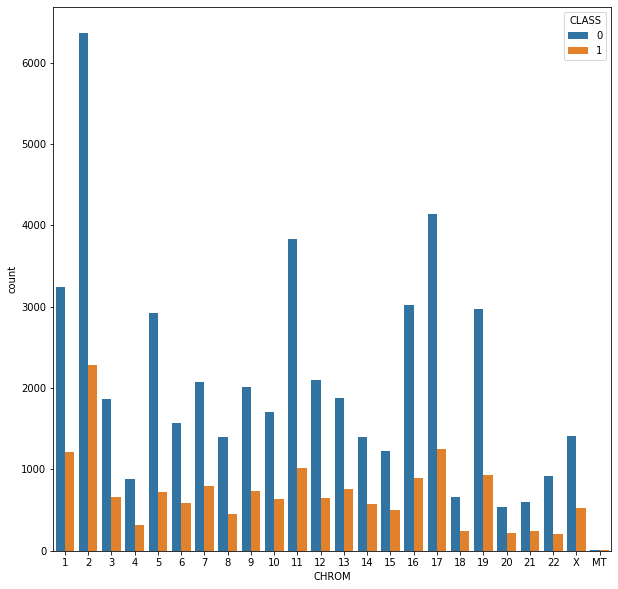

In [86]:
# distribution of classes across chromosomes 
fig = plt.figure(figsize = (10, 10))
sns.countplot(x= 'CHROM', data = df, hue = 'CLASS')

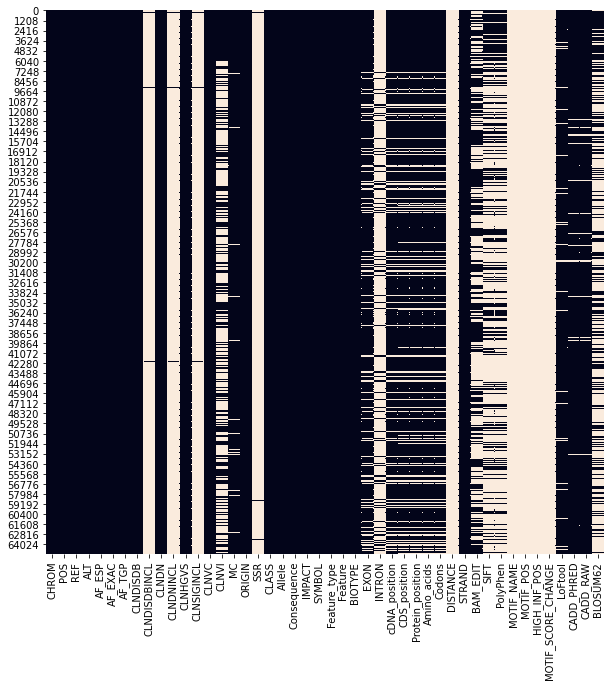

In [87]:
# heatmap of null values
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df.isnull(), cbar = False)

In [97]:
# remove null values, and cols with < 1000 unique values 
keep = ['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP',
       'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'ORIGIN', 'CLASS',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 
       'Feature', 'BIOTYPE', 'STRAND','CADD_PHRED', 'CADD_RAW']
df = df[keep]
remove = []
for i in df.columns.values:
    if df[i].nunique() < 1000:
        remove.append(i)
df = df[remove]
df['CHROM'] = df['CHROM'].astype(str)

In [98]:
# feature hashing and one-hot encoding (to deal with string variables)
hasher = FeatureHasher(n_features = 5, input_type = 'string')
REF = pd.DataFrame(hasher.fit_transform(df['REF']).toarray())
nameList = {}
for i in REF.columns.values:
    nameList[i] = "REF"+str(i+1)
REF.rename(columns = nameList, inplace = True)

ALT = pd.DataFrame(hasher.fit_transform(df['ALT']).toarray())
nameList = {}
for i in ALT.columns.values:
    nameList[i] = "ALT"+str(i+1)
ALT.rename(columns = nameList, inplace = True)

CHROM = pd.DataFrame(hasher.fit_transform(df['CHROM']).toarray())
nameList = {}
for i in CHROM.columns.values:
    nameList[i] = "CHROM"+str(i+1)
CHROM.rename(columns = nameList, inplace = True)

Allele = pd.DataFrame(hasher.fit_transform(df['Allele']).toarray())
nameList = {}
for i in Allele.columns.values:
    nameList[i] = "Allele"+str(i+1)
Allele.rename(columns = nameList, inplace = True)


Consequence = pd.DataFrame(hasher.fit_transform(df['Consequence']).toarray())
nameList = {}
for i in Consequence.columns.values:
    nameList[i] = "Consequence"+str(i+1)
Consequence.rename(columns = nameList, inplace = True)

In [99]:
# one hot encoding 
CLNVC = pd.get_dummies(df['CLNVC'])
IMPACT = pd.get_dummies(df['IMPACT'])
BIOTYPE = pd.get_dummies(df['BIOTYPE'], drop_first=True)
STRAND = pd.get_dummies(df['STRAND'], drop_first=True)

In [100]:
df = pd.concat([REF, ALT, CHROM, Allele, Consequence , CLNVC, IMPACT, BIOTYPE,STRAND, df['CLASS']], axis=1)
df = df.dropna()
df.rename(columns={1 : "one"}, inplace = True)

In [113]:
y = df['CLASS']
x = df.drop(columns=['CLASS'], axis = 1)
df.head() # 65188 data points and 29 cols

,REF1,REF2,REF3,REF4,REF5,ALT1,ALT2,ALT3,ALT4,ALT5,CHROM1,CHROM2,CHROM3,CHROM4,CHROM5,Allele1,Allele2,Allele3,Allele4,Allele5,Consequence1,Consequence2,Consequence3,Consequence4,Consequence5,Deletion,Duplication,Indel,Insertion,Inversion,Microsatellite,single_nucleotide_variant,HIGH,LOW,MODERATE,MODIFIER,protein_coding,one,CLASS
0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,3.0,-1.0,0.0,0.0,-4.0,0,0,0,0,0,0,1,0,0,1,0,1,1,0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,-1.0,0.0,0.0,-4.0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,-1.0,0.0,0.0,-4.0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,-1.0,0.0,0.0,-4.0,0,0,0,0,0,0,1,0,0,1,0,1,1,0
4,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,3.0,-1.0,0.0,0.0,-4.0,0,0,0,0,0,0,1,0,0,1,0,1,1,0


In [102]:
# split into train-test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [106]:
# decision tree model
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(x_train, y_train)
y_test_pred = dtree.predict(x_test)

In [111]:
print( "Classification Report :\n ", classification_report(y_test, y_test_pred))

Classification Report :
                precision    recall  f1-score   support

           0       0.75      1.00      0.86     12252
           1       0.18      0.00      0.00      4045

    accuracy                           0.75     16297
   macro avg       0.47      0.50      0.43     16297
weighted avg       0.61      0.75      0.65     16297

